# Gold Prices: Time series Forecasting

- Exploratory analysis
- Linear regression
- Final model

Data: Monthly Gold Prices

[MarkdownVSCode](https://code.visualstudio.com/docs/languages/markdown)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Import model libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Suppress the warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the price data
df = pd.read_csv("https://raw.githubusercontent.com/Jdmuci/Python_practices/main/monthly_goldprices.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [3]:
df.shape   #Rows, columns

(847, 2)

## Exploratory Analysis

In [4]:
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [5]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [6]:
df['month'] = date
df.drop('Date',axis=1,inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


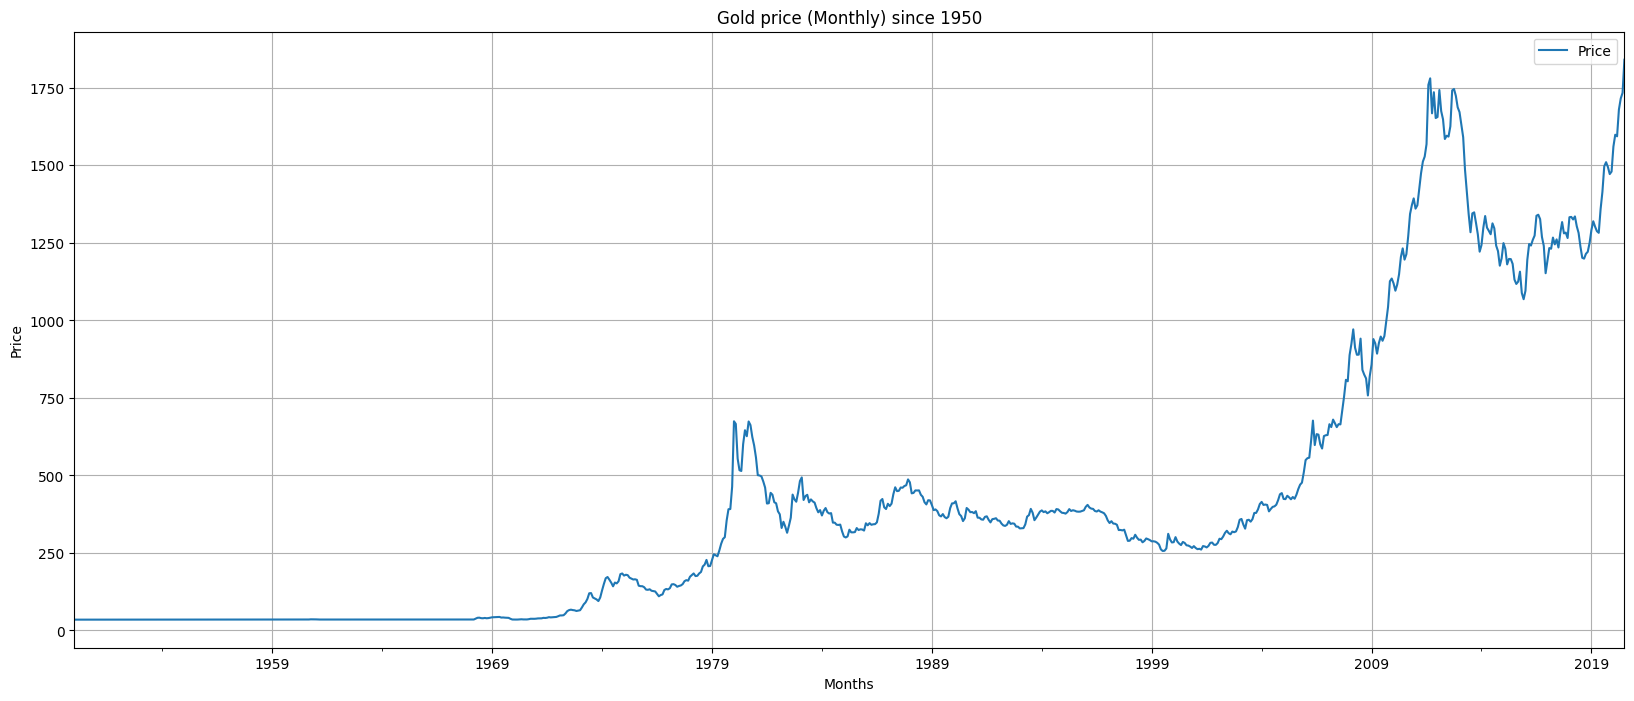

In [7]:
df.plot(figsize=(20,8))
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

In [8]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807




Inference

    The Average gold price in last 70 years is $416.56

    Only 25% of the time, the gold price is above $447.07

    Highest Gold price ever touched is $1840.81



## Visual analysis

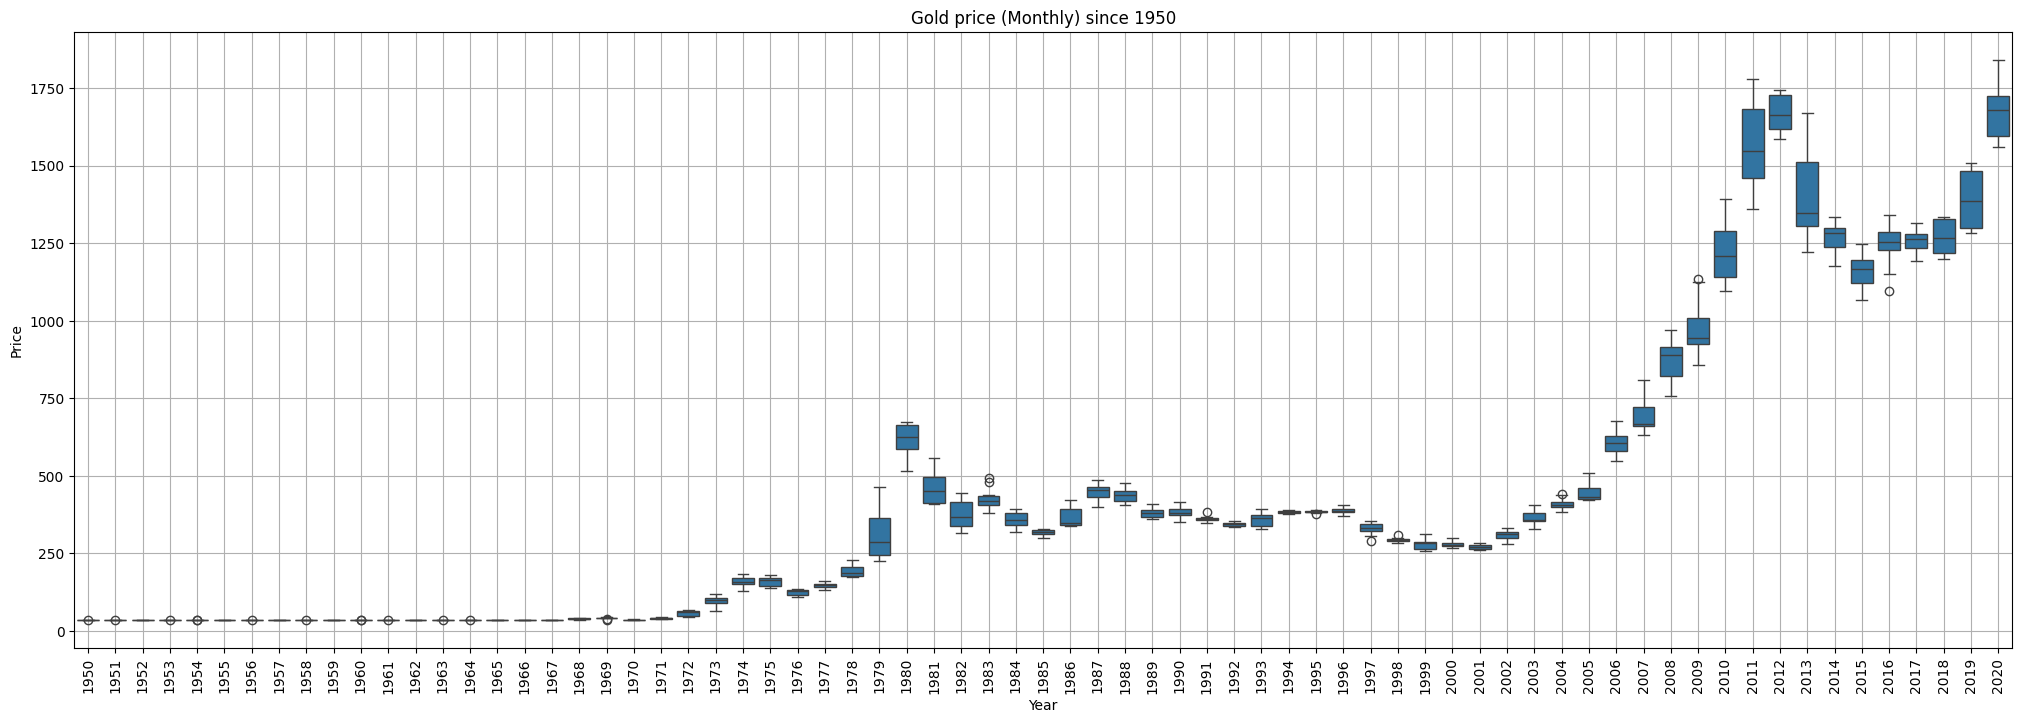

In [9]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();


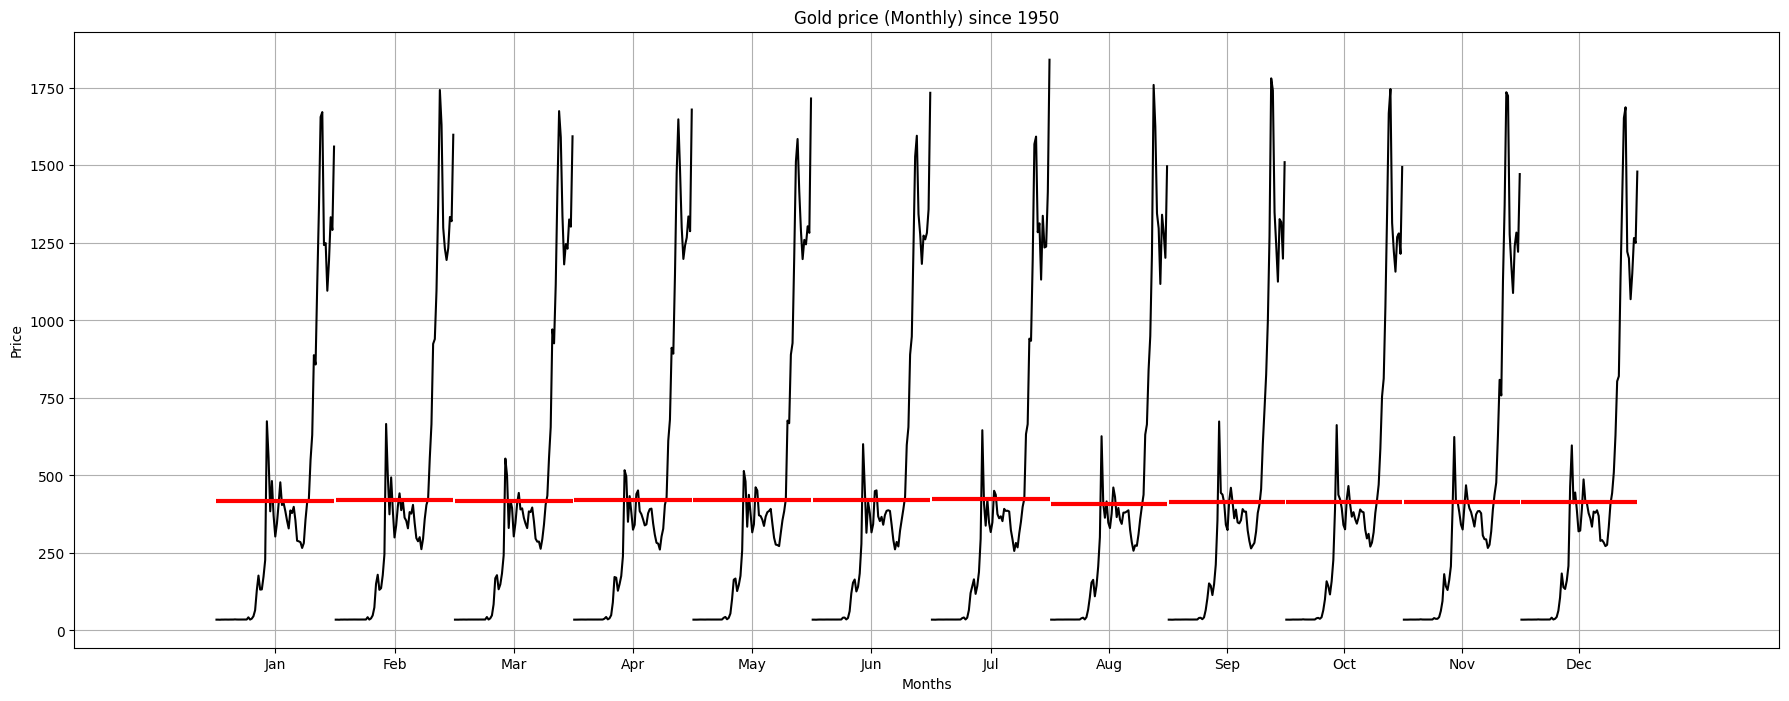

In [10]:


from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))

month_plot(df,ylabel='Gold price',ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();



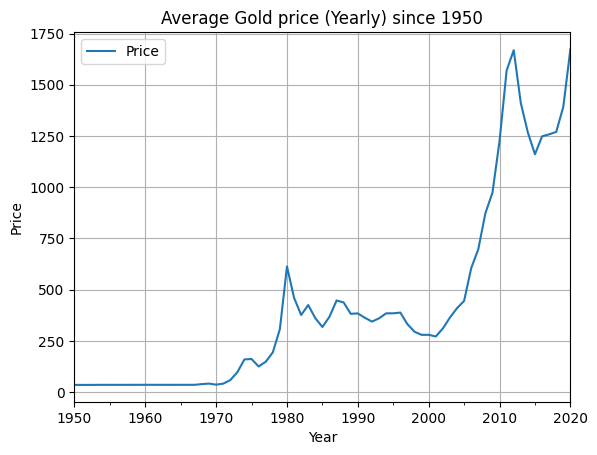

In [11]:
# Average gold price per year trend since 1950

df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

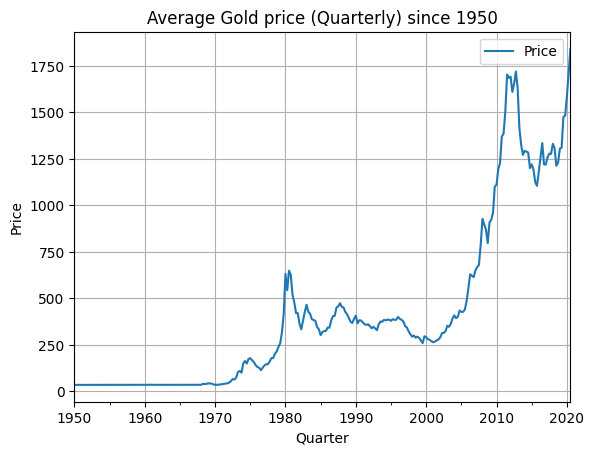

In [12]:


# Average gold price per quarter trend since 1950
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("Average Gold price (Quarterly) since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()



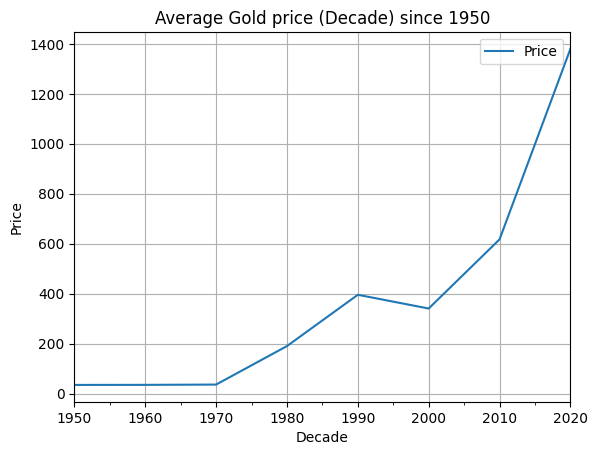

In [13]:


# Average gold price per decade trend since 1950
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot();
plt.title("Average Gold price (Decade) since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()




Analysis in Coefficient of variation

    The coefficient of variation (CV) is a statistical measure of the relative dispersion of data points in a data series around the mean.
    In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments.
    The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.

Let us look at the CV values for each year in Gold price


In [14]:
# Coefficient of variation in price
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['CoV_pct'] = ((df_1['Std']/df_1['Mean'])*100).round(2)
df_1.head()

,Mean,Std,CoV_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


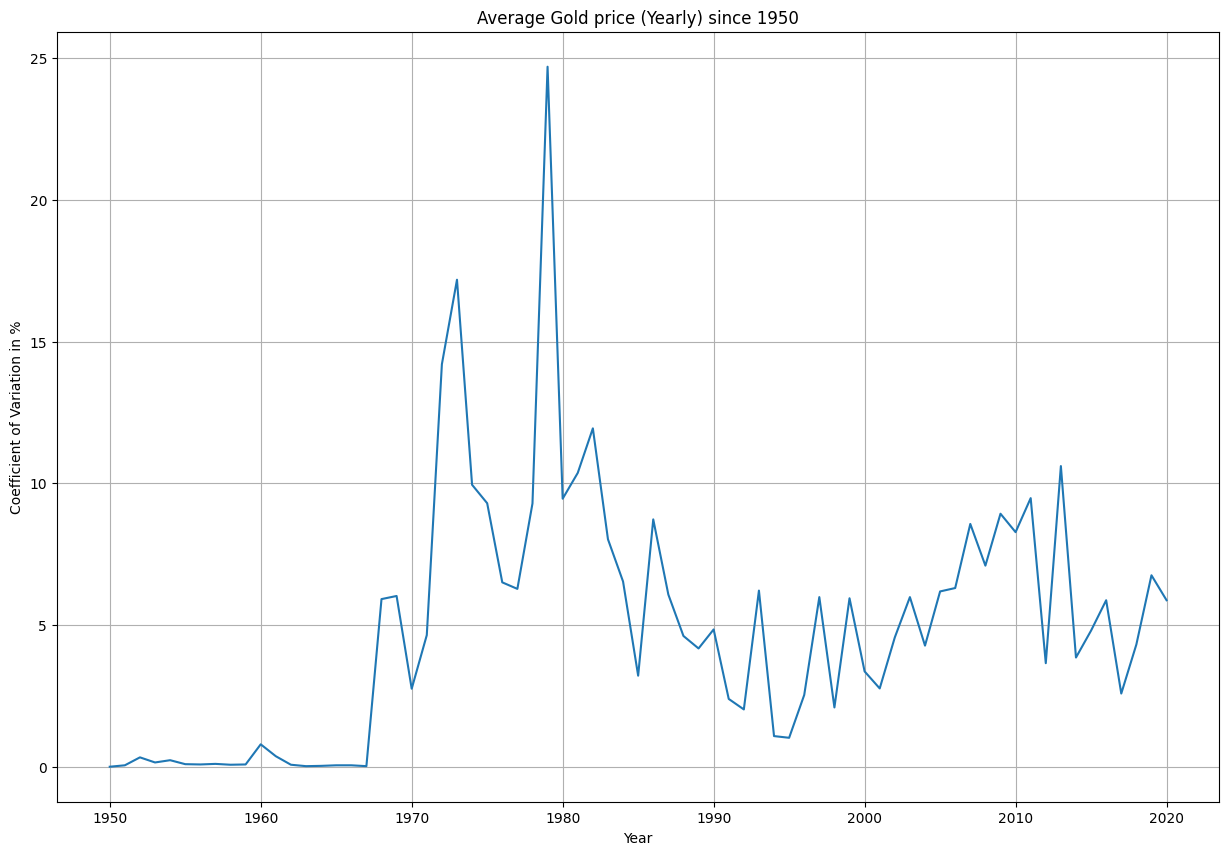

In [15]:
# Average gold price per year trend since 1950
fig, ax = plt.subplots(figsize=(15,10))
df_1['CoV_pct'].plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Coefficient of Variation in %")
plt.grid()



Inference

    The CV value reached its highest in year 1978 near to 25%, which could have made the asset as highly risky
    But in 2020, the CV value is closer to 5%, which makes the asset viable for good investment



## **Time series: Forecasting Models**

### Train - Test split to build Time series forecasting models

In [16]:
train    =   df[df.index.year <= 2015]
test     =   df[df.index.year > 2015]


In [17]:
print(df.head(5))
# se cambió a una serie de tiempo (Date es ahora month desde el primer paso de Exploratory analysis)

            Price
month            
1950-01-31  34.73
1950-02-28  34.73
1950-03-31  34.73
1950-04-30  34.73
1950-05-31  34.73


In [18]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


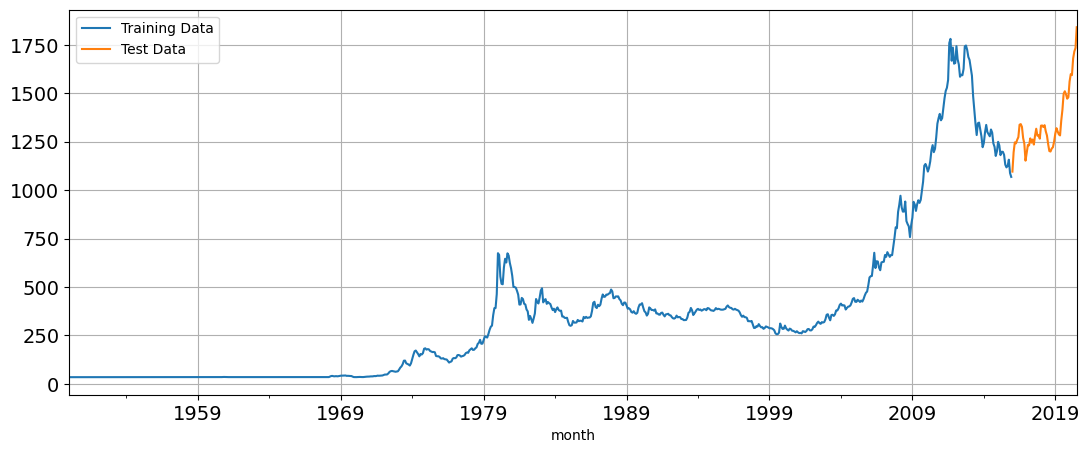

In [19]:
#Train and test graph
train['Price'].plot(figsize=(13,5), fontsize=14)
test['Price'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

### Model 1: Linear Regression

In [20]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [21]:
LR_train = train.copy()
LR_test = test.copy()


In [22]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [23]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)



LinearRegression()

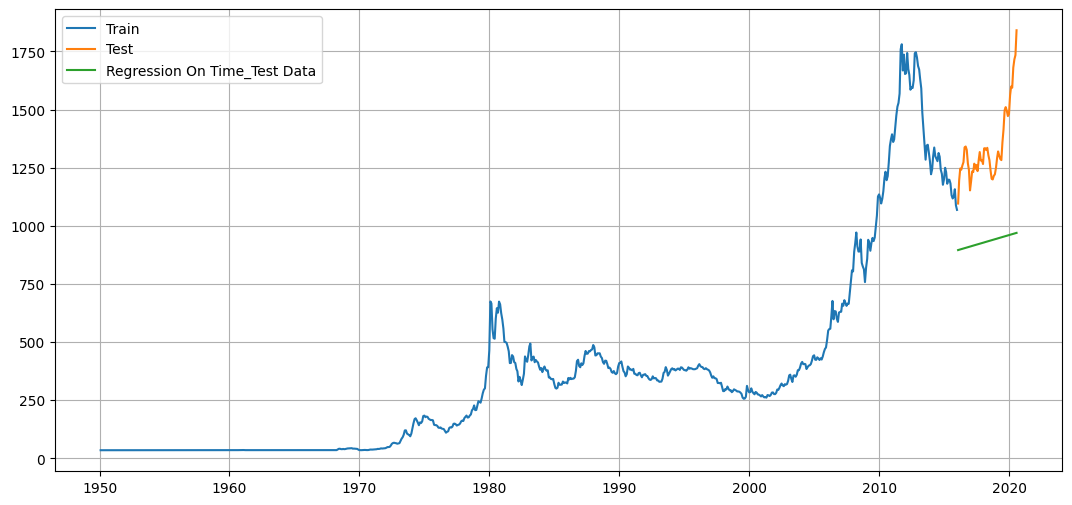

In [24]:
test_predictions_model1         = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(LR_test['forecast'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

In [25]:
def mape(actual,pred):
    return round((np.mean(abs(actual-pred)/actual))*100,2)


In [26]:
# Get MAPE of the model

mape_model1_test = mape(test['Price'].values,test_predictions_model1)
print("For RegressionOnTime forecast on the Test Data,  MAPE is %3.3f" %(mape_model1_test),"%")


For RegressionOnTime forecast on the Test Data,  MAPE is 29.760 %


In [27]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model1_test]},index=['RegressionOnTime'])
results

,Test MAPE (%)
RegressionOnTime,29.76


### Final Model:

In [28]:
final_model =  ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='additive').fit(smoothing_level=0.4,
                                                           smoothing_trend=0.3,
                                                           smoothing_seasonal=0.6)

In [29]:
MAPE_final_model = mape(df['Price'].values,final_model.fittedvalues)

print('MAPE:',MAPE_final_model)


MAPE: 17.24


In [30]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction = final_model.forecast(steps=len(test))

In [31]:
# Compute 95% confidence interval for predicted values
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1),
                        'prediction':prediction,
                        'upper_CI': prediction + 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


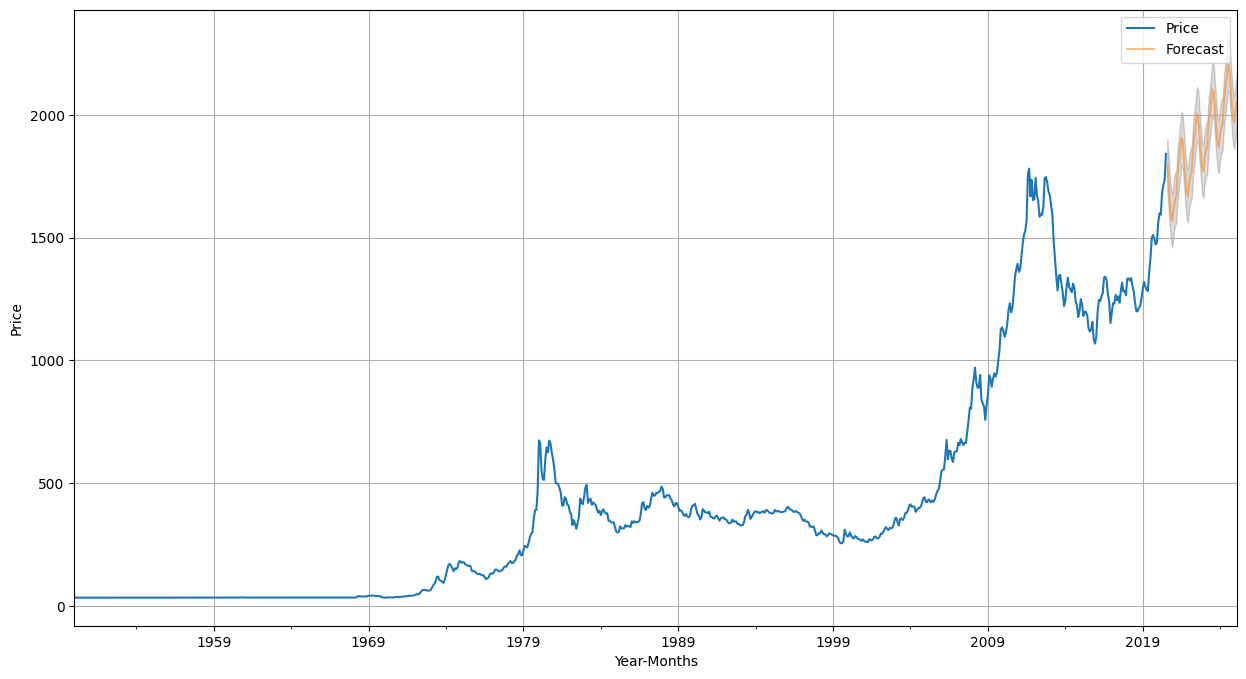

In [32]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(15,8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Price')
plt.legend(loc='best')
plt.grid()
plt.show()